In [1]:
import os

import random

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box


bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran": {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    # "Frankfurt": {"minx": 8.55, "miny": 50.00, "maxx": 8.80, "maxy": 50.20},
    "Frankfurt": {"minx": 8.48, "miny": 50.05, "maxx": 8.78, "maxy": 50.2188},
    "Aachen": {"minx": 6.05, "miny": 50.70, "maxx": 6.10, "maxy": 50.80},
    "Istanbul": {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20}

}

foldernames = {
    #"Tehran": "iran-latest-free.shp",
    # "Frankfurt": "hessen-latest-free.shp",
    # "Istanbul": "turkey-latest-free.shp",
    "Darmstadt": "hessen-latest-free.shp",
}

In [2]:
def save_file(foldername_out, city, color_sets):


    def load_stuff():
        shp_folder = "data/" + foldernames[city]

        bounding_box_size = bounding_boxes[city]

        # Create a bounding box as a GeoDataFrame
        bounding_box = gpd.GeoDataFrame(
            {"geometry": [box(bounding_box_size["minx"], bounding_box_size["miny"], bounding_box_size["maxx"], bounding_box_size["maxy"])]}, 
            crs="EPSG:4326"  # WGS84 coordinate system
        )

        # Function to load only the data intersecting the bounding box
        def load_filtered_data(filepath, bounding_box):
            gdf = gpd.read_file(filepath, mask=bounding_box)
            return gdf


        railroads_path = shp_folder + "/gis_osm_railways_free_1.shp"

        normal_roads_path = shp_folder + "//gis_osm_roads_free_1.shp"

        # primary_roads_path = "turkey-latest-free.shp//gis_roads_primary.shp"

        landuse_path = shp_folder + "//gis_osm_landuse_a_free_1.shp"
        waterways_path = shp_folder + "//gis_osm_waterways_free_1.shp"
        water_path = shp_folder + "//gis_osm_water_a_free_1.shp"


        print("Read files")
        # Load shapefiles
        railroads = load_filtered_data(railroads_path, bounding_box)

        normal_roads = load_filtered_data(normal_roads_path, bounding_box)
        primary_roads = normal_roads.loc[normal_roads["fclass"]=="primary"]
        water = load_filtered_data(water_path, bounding_box)

        landuse = load_filtered_data(landuse_path, bounding_box)
        waterways = load_filtered_data(waterways_path, bounding_box)

        if city == "Istanbul":
            geoboundaries_path = "geoBoundaries-TUR-ADM0-all//geoBoundaries-TUR-ADM0.shp"

            # Load the provided shapefile
            geoboundaries = gpd.read_file(geoboundaries_path)

            # Reproject to EPSG:4326 if needed
            if geoboundaries.crs != "EPSG:4326":
                geoboundaries = geoboundaries.to_crs("EPSG:4326")
                print(f"Reprojected CRS: {geoboundaries.crs}")

            # Clip the geoboundaries using the bounding box
            clipped_geoboundaries = gpd.overlay(geoboundaries, bounding_box, how='intersection')
        else:
            clipped_geoboundaries = None

        print("Filter landuse")
        # Filter landuse based on fclass values
        landuse_filtered = landuse[landuse['fclass'].isin(['forest', 'park', 'farmland', 'meadow', 'allotments'])]

        return railroads, normal_roads, primary_roads, water, landuse_filtered, waterways, clipped_geoboundaries, bounding_box_size

    # Call the inner function to get the data
    railroads, normal_roads, primary_roads, water, landuse_filtered, waterways, clipped_geoboundaries, bounding_box_size = load_stuff()


    # Define the labels
    labels = ["bg", "road", "rail", "landscape", "land"]

    for idx, color_set in enumerate(color_sets):
        print(f"now using colorset {idx}")
        colors = {label: color_set[i] for i, label in enumerate(labels)}

        fig, ax = plt.subplots(figsize=(12, 12))


        bg_color = colors["bg"]
        road_color = colors["road"]
        rail_color = colors["rail"]
        landscape_color = colors["landscape"]
        land_color = colors["land"]
        water_color = colors["bg"]

        if city == "Istanbul":
            clipped_geoboundaries.plot(ax=ax, facecolor=land_color, linewidth=0, label="Country Boundaries")
        else:
            bg_color = land_color

        fig.patch.set_facecolor(bg_color)
        ax.set_facecolor(bg_color)

        landuse_filtered.plot(ax=ax, color=landscape_color)
        waterways.plot(ax=ax, color=water_color, linewidth=0.5)

        water.plot(ax=ax, color=water_color)

        #normal_roads.plot(ax=ax, color=road_color, linewidth=0.1)
        primary_roads.plot(ax=ax, color=road_color, linewidth=0.2)

        railroads.plot(ax=ax, color=rail_color, linewidth=0.3)

        ax.set_xlim(bounding_box_size["minx"], bounding_box_size["maxx"])
        ax.set_ylim(bounding_box_size["miny"], bounding_box_size["maxy"])

        ax.axis('off')

        plt.savefig(foldername_out + city + f"_{idx}.pdf", dpi=300, bbox_inches='tight', facecolor=bg_color)
        plt.close()


In [3]:
# Define the color sets
color_sets_original = [
    ["#19535F", "#0B7A75", "#D7C9AA", "#7B2D26", "#F0F3F5"],
    #["#001514", "#FFFFFF", "#6B0504", "#A3320B", "#00A7E1"],
    #["#044389", "#FCFF4B", "#FFAD05", "#7CAFC4", "#5995ED"]
]


color_sets = []
for color_set in color_sets_original:
    for jdx in range(6):  # Generate 5 assignments
        shuffled_colors = color_set.copy()
        random.shuffle(shuffled_colors)  # Shuffle colors
        color_sets.append(shuffled_colors)

In [4]:
# import random
# from matplotlib import colors as mcolors

# def generate_distinct_colors(n):
#     # Get a large pool of distinct colors from matplotlib named colors
#     all_colors = list(mcolors.CSS4_COLORS.values())
#     random.shuffle(all_colors)  # Shuffle to ensure randomness
    
#     color_sets = []
#     for _ in range(n):
#         # Randomly pick 5 unique colors
#         color_set = random.sample(all_colors, 5)
#         color_sets.append(color_set)
#     return color_sets

# # Generate 10 sets of 5 distinct colors
# n = 30
# color_sets = generate_distinct_colors(n)

# # Display the color sets
# color_sets


In [5]:

foldername_out = "output/" +  input("Give your foldername") + "/"

os.mkdir(foldername_out)

for city in foldernames.keys():
    print(f"now calculating {city}")

    save_file(foldername_out, city,color_sets)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000024C5C290970>>
Traceback (most recent call last):
  File "c:\Users\Breuer\Documents\git\citymapper\env\lib\site-packages\ipykernel\ipkernel.py", line 796, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
KeyboardInterrupt: 


FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'output//'

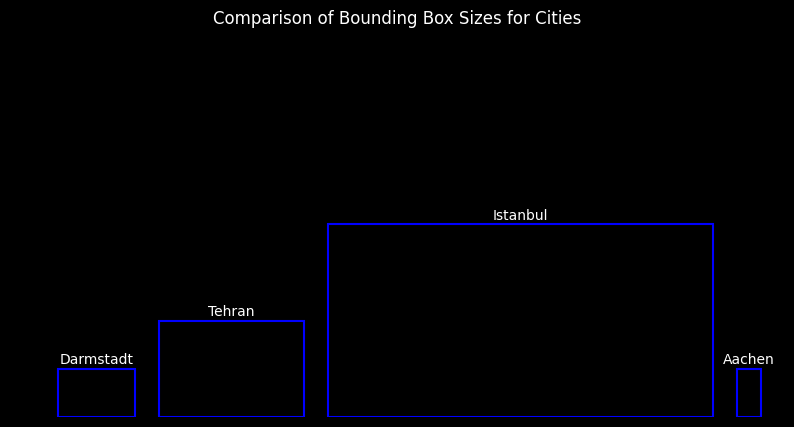

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define bounding boxes for the cities
bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran": {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Istanbul": {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20},
    "Aachen": {"minx": 6.05, "miny": 50.70, "maxx": 6.10, "maxy": 50.80},
}

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Assign unique x-offsets for better visualization
x_offset = 0
for city, bbox in bounding_boxes.items():
    width = bbox["maxx"] - bbox["minx"]
    height = bbox["maxy"] - bbox["miny"]

    # Draw rectangle for the bounding box
    rect = patches.Rectangle(
        (x_offset, 0),  # Bottom-left corner of rectangle
        width,          # Width of rectangle
        height,         # Height of rectangle
        edgecolor="blue",
        facecolor="none",
        linewidth=1.5,
        label=city
    )
    ax.add_patch(rect)

    # Annotate city name
    ax.text(
        x_offset + width / 2,
        height + 0.01,
        city,
        ha="center",
        fontsize=10
    )
    
    # Increase x_offset for next rectangle
    x_offset += width + 0.05

# Adjust axes
ax.set_xlim(-0.1, x_offset)
ax.set_ylim(0, 0.8)
ax.set_aspect('equal')
ax.set_title("Comparison of Bounding Box Sizes for Cities")
ax.axis('off')

# Show plot
plt.show()


In [3]:
import folium
from shapely.geometry import box

# Define bounding boxes for the cities
bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran":    {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Istanbul":  {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20},
    "Aachen":    {"minx": 6.02,  "miny": 50.73, "maxx": 6.19, "maxy": 50.81},
    "Frankfurt": {"minx": 8.48, "miny": 50.05, "maxx": 8.78, "maxy": 50.2188},
}

# Create a folium map for each city
maps = {}
for city, bbox in bounding_boxes.items():
    center_lat = (bbox["miny"] + bbox["maxy"]) / 2
    center_lon = (bbox["minx"] + bbox["maxx"]) / 2
    folium_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

    # Draw the bounding box
    bounding_box_geom = box(bbox["minx"], bbox["miny"], bbox["maxx"], bbox["maxy"])
    folium.GeoJson(
        bounding_box_geom.__geo_interface__,
        style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0},
    ).add_to(folium_map)

    # Store the map
    maps[city] = folium_map

# Display the maps for each city
for city, city_map in maps.items():
    print(f"Map for {city}")
    display(city_map)


ModuleNotFoundError: No module named 'folium'

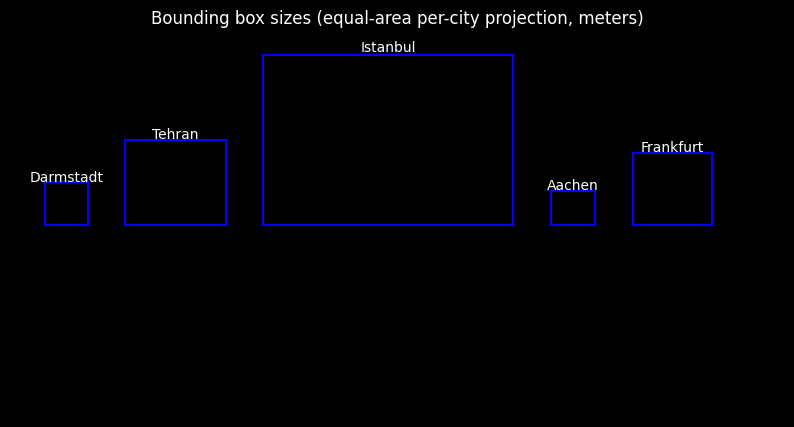

In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
from shapely.geometry import box

# --- Input -------------------------------------------------------------------------
bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    "Tehran":    {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Istanbul":  {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20},
    "Aachen":    {"minx": 6.02,  "miny": 50.73, "maxx": 6.19, "maxy": 50.81},
    "Frankfurt": {"minx": 8.48, "miny": 50.05, "maxx": 8.78, "maxy": 50.2188},
}

# --- Helper: build a local equal-area CRS per city ----------------------------------
def local_albers_equal_area(minx, miny, maxx, maxy):
    """
    Construct a city-centered Albers Equal Area (AEA) CRS for accurate areas.
    Uses parallels at lat0 ± 10° which works well for small-to-medium regions.
    Returns a PROJ string accepted by GeoPandas/pyproj.
    """
    lat0 = 0.5 * (miny + maxy)  # latitude of origin (city mid-lat)
    lon0 = 0.5 * (minx + maxx)  # central meridian (city mid-lon)
    lat1 = lat0 - 10.0          # first standard parallel
    lat2 = lat0 + 10.0          # second standard parallel
    return (
        f"+proj=aea +lat_1={lat1} +lat_2={lat2} +lat_0={lat0} +lon_0={lon0} "
        f"+datum=WGS84 +units=m +no_defs +type=crs"
    )

# --- Build polygons in WGS84 --------------------------------------------------------
records = []
for city, b in bounding_boxes.items():
    geom = box(b["minx"], b["miny"], b["maxx"], b["maxy"])
    records.append({"city": city, "geometry": geom, **b})

gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")

# --- Reproject each bbox to its own local AEA, measure, and plot --------------------
fig, ax = plt.subplots(figsize=(10, 5))

x_offset_m = 0.0
gap_m = 10_000  # 10 km between rectangles

for _, row in gdf.iterrows():
    city = row["city"]
    # Build a 1-row GeoDataFrame for this city and project to its local equal-area CRS
    proj = local_albers_equal_area(row["minx"], row["miny"], row["maxx"], row["maxy"])
    g1 = gpd.GeoDataFrame([{"city": city, "geometry": row["geometry"]}], crs=gdf.crs).to_crs(proj)

    # Get width/height from projected bounds (meters)
    minx_p, miny_p, maxx_p, maxy_p = g1.total_bounds
    width_m = maxx_p - minx_p
    height_m = maxy_p - miny_p

    # Draw a rectangle with the exact projected width/height (area true)
    rect = patches.Rectangle(
        (x_offset_m, 0.0),
        width_m,
        height_m,
        edgecolor="blue",
        facecolor="none",
        linewidth=1.5,
    )
    ax.add_patch(rect)

    # Label above
    ax.text(
        x_offset_m + width_m / 2.0,
        height_m + (0.02 * max(height_m, 1.0)),
        city,
        ha="center",
        fontsize=10,
    )

    x_offset_m += width_m + gap_m

# Make area/shape visually honest
ax.set_aspect("equal", adjustable="datalim")
ax.set_xlim(-0.05 * x_offset_m, x_offset_m + 0.05 * x_offset_m)
ax.set_ylim(0, ax.get_ylim()[1] * 1.1 if ax.get_ylim()[1] > 0 else max(1000, height_m * 1.1))
ax.axis("off")
ax.set_title("Bounding box sizes (equal-area per-city projection, meters)")

plt.show()


In [1]:
from utils import save_a0_three_axes_same_scale


# Example inputs
bounding_boxes = {
    "Darmstadt": {"minx": 8.56, "miny": 49.83, "maxx": 8.72, "maxy": 49.93},
    # "Tehran":    {"minx": 51.20, "miny": 35.60, "maxx": 51.50, "maxy": 35.80},
    "Tehran":    {"minx": 51.16, "miny": 35.60, "maxx": 51.57, "maxy": 35.81},
    "Istanbul":  {"minx": 28.65, "miny": 40.80, "maxx": 29.45, "maxy": 41.20},
    "Aachen":    {"minx": 6.02,  "miny": 50.73, "maxx": 6.19, "maxy": 50.81},
    "Frankfurt": {"minx": 8.48, "miny": 50.05, "maxx": 8.78, "maxy": 50.2188},
}

foldernames = {
    "Frankfurt": "hessen-latest-free.shp",
    "Istanbul": "turkey-latest-free.shp",
    # add entries as needed for your cities
    "Darmstadt": "hessen-latest-free.shp",
    "Aachen":    "koeln-regbez-latest-free.shp",
    "Tehran":    "iran-latest-free.shp",
}

# Colors (per your LABELS order: bg, road, rail, landscape, land)
palette = ["#19535F", "#0B7A75", "#D7C9AA", "#7B2D26", "#F0F3F5"]
def colors_from_palette(p):  # helper
    return {"bg": p[0], "road": p[4], "rail": p[1], "landscape": p[3], "land": p[2]}

colors_per_city = {
    "Istanbul":     colors_from_palette(palette),
    "Tehran":       colors_from_palette(palette),
    "Darmstadt":    colors_from_palette(palette),
    "Frankfurt":    colors_from_palette(palette),
    "Aachen":       colors_from_palette(palette),
}

# 1) Istanbul on its own A0 page
# save_a0_single_city_page(
#     city="Istanbul",
#     foldernames=foldernames,
#     bounding_boxes=bounding_boxes,
#     colors=colors_per_city["Istanbul"],
#     out_pdf="output/istanbul_A0.pdf",
#     title="Istanbul",
# )

# 2) Tehran + Darmstadt + Aachen on one A0 page (stacked)
save_a0_three_axes_same_scale(
    cities=["Istanbul", "Tehran", "Frankfurt", "Aachen", "Darmstadt", ],
    foldernames=foldernames,
    bounding_boxes=bounding_boxes,
    colors_per_city=colors_per_city,
    out_pdf="output/four_cities_A0_g.pdf"
)
